In [1]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from sklearn.cluster import KMeans
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import colorsys
import json
from json import JSONEncoder
#from rembg import remove
import pickle

import warnings
warnings.filterwarnings("ignore")

/var/folders/jn/jszhw2j95nn6slg9qsgwfv4h0000gq/T/ipykernel_48433/1216545663.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
DATADIR = 'dataset'
CATEGORIES = ['ocean','land']

IMG_9974_27_93.png


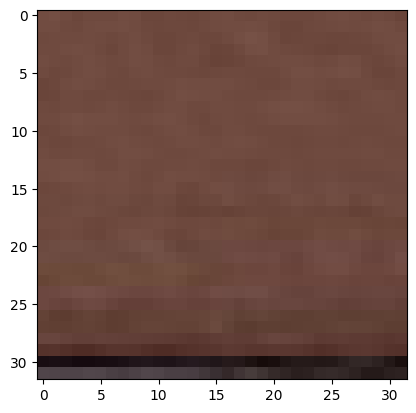

IMG_9974_12_28.png


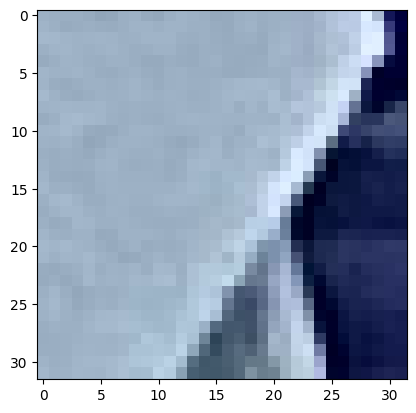

In [3]:
for category in CATEGORIES:
    path=os.path.join(DATADIR, category)
    for img in os.listdir(path):
        split_tup = os.path.splitext(img)
        if len(split_tup) > 1 and split_tup[len(split_tup)-1] == ".png":
            img_array=cv2.imread(os.path.join(path,img), cv2.IMREAD_UNCHANGED)
            print(img)
            plt.imshow(img_array)
            plt.show()
            break
    #break

In [4]:
def get_image(image_path):
    image = cv2.imread(image_path)
    #image = remove(image)
    image = cv2.cvtColor(image)
    return image
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

def extract_features(path, img, split_tup):
    image_path = os.path.join(path, img)
    json_file = split_tup[0] + ".json"
    json_path = os.path.join(path, json_file)
    if os.path.exists(json_path):
        # Opening JSON file
        f = open(json_path)
        json_details = json.load(f)
        return json_details["rgb_colors"]
        # has_high_hsl = False
        # for hsl in hsl_color_values:
        #     if hsl[1] > 0.5:
        #         has_high_hsl = True
                
        # if has_high_hsl and split_tup[0].startswith("plastic"):
        #     return hsl_color_values
        # else:
        #     if not has_high_hsl:
        #         return hsl_color_values
        #     else:
        #         return []
    else:
        image = get_image(image_path)
        number_of_colors = 10
        modified_image = image.reshape(image.shape[0]*image.shape[1], 3)
        #nobg_image = remove(modified_image)
        clf = KMeans(n_clusters = number_of_colors)
        labels = clf.fit_predict(modified_image)
        
        counts = Counter(labels)

        center_colors = clf.cluster_centers_

        # We get ordered colors by iterating through the keys
        ordered_colors = [center_colors[i] for i in counts.keys()]
        hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
        rgb_colors = [ordered_colors[i] for i in counts.keys()]
        hsl_color_values = []

        for i in range(len(rgb_colors)):
            rgb_color = rgb_colors[i]
            hsl_color_val = colorsys.rgb_to_hsv(rgb_color[0],rgb_color[1],rgb_color[2])
            hsl_color_values.append(hsl_color_val)

        
        json_details = {"rgb_colors": rgb_colors,
                        "hex_colors": hex_colors,
                        "hsl_color_values": hsl_color_values}
        # Serializing json
        json_object = json.dumps(json_details, indent=4, cls=NumpyArrayEncoder)
 
        # Writing to sample.json
        with open(json_path, "w") as outfile:
            outfile.write(json_object)

        return rgb_colors

ocean 0 0
land 0 1


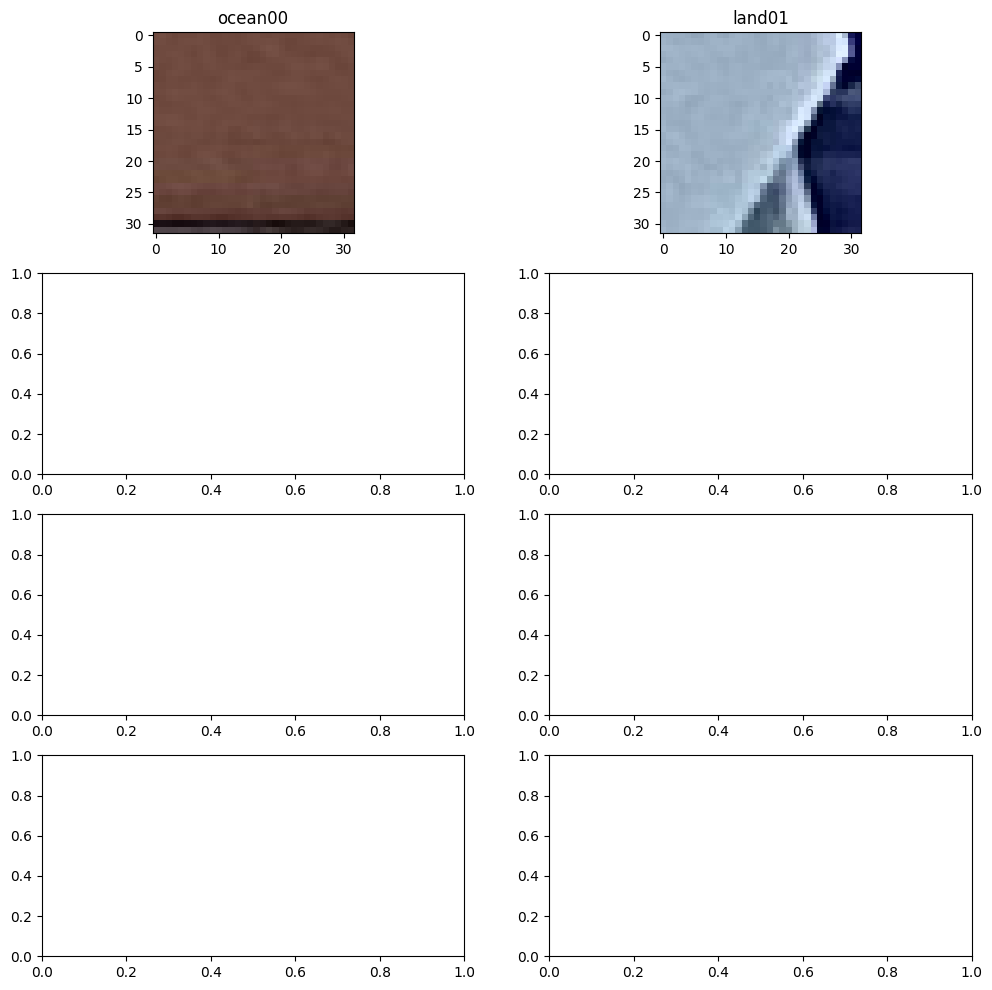

In [5]:
cols=2
rows=4
col_index=0
row_index=0
f, axarr = plt.subplots(rows,cols,figsize=(12, 12))
for category in CATEGORIES:
    path=os.path.join(DATADIR, category)
    for img in os.listdir(path):
        split_tup = os.path.splitext(img)
        if len(split_tup) > 1 and split_tup[len(split_tup)-1] == ".png":
            img_array=cv2.imread(os.path.join(path,img),cv2.COLOR_BGR2RGB)
            axarr[row_index,col_index].imshow(img_array)
            axarr[row_index,col_index].set_title(category+str(row_index)+str(col_index))
            print(category,row_index,col_index)
            break
    col_index=col_index+1
    if(col_index==cols):
        row_index=row_index+1
        col_index=0

In [6]:
training_data=[]
def create_training_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            split_tup = os.path.splitext(img)
            if len(split_tup) > 1 and split_tup[len(split_tup)-1] == ".png":
                try:
                    features = extract_features(path, img, split_tup)
                    if len(features) > 0:
                        training_data.append([features,class_num])
                except Exception as e:
                    print(e)
                    pass
                
create_training_data()  

In [7]:
lenofimage = len(training_data)

In [8]:
X=[]
y=[]

for categories, label in training_data:
    X.append(categories)
    y.append(label)
X= numpy.array(X).reshape(lenofimage,-1)

# numpy.isnan(X.any()) #and gets False

#index = 0
#for i in X[:,0]:
#    if not numpy.isfinite(i):
#        print(index, i)
#    index +=1

numpy.isfinite(X.all()) #and gets True


# X = tf.keras.utils.normalize(X, axis = 1)

True

In [9]:
X.shape

(2940, 30)

In [10]:
X=X/255

In [11]:
X[1]

array([0.50224291, 0.52563126, 0.61125688, 0.53211186, 0.55210543,
       0.63612986, 0.55857843, 0.57622549, 0.65710784, 0.49136476,
       0.51564732, 0.60340216, 0.43909685, 0.46999406, 0.55769459,
       0.4746621 , 0.50001904, 0.58652199, 0.46401833, 0.49314999,
       0.58008658, 0.48132303, 0.50865518, 0.59481085, 0.45228758,
       0.48221289, 0.57021475, 0.51492503, 0.53716263, 0.62399077])

In [12]:
y=numpy.array(y)

In [13]:
y.shape

(2940,)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [15]:
from sklearn.svm import SVC
svc = SVC(kernel='linear',gamma='auto')
svc.fit(X_train, y_train)

pickle.dump(svc, open("color_svm.sav", 'wb'))

In [16]:
y2 = svc.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score
print("Accuracy on unknown data is",accuracy_score(y_test,y2))

Accuracy on unknown data is 0.9945578231292517


In [18]:
from sklearn.metrics import classification_report
print("Accuracy on unknown data is",classification_report(y_test,y2))

Accuracy on unknown data is               precision    recall  f1-score   support

           0       0.99      1.00      0.99       371
           1       1.00      0.99      0.99       364

    accuracy                           0.99       735
   macro avg       0.99      0.99      0.99       735
weighted avg       0.99      0.99      0.99       735



In [19]:
result = pd.DataFrame({'original' : y_test,'predicted' : y2})
result

,original,predicted
0,1,1
1,1,1
2,0,0
3,0,0
4,1,1
...,...,...
730,0,0
731,0,0
732,1,1
733,1,1
